### Process the Snow Course Data from AK
This notebook takes downloaded snow course data and turns it into the
inputs needed for the calibration workflow

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
from shapely import geometry as sgeom


# Import the snow course data downloaded from Dave
# NOTE: I altered the date column to be year, mon, day
pd_data = pd.read_csv('/nfs/attic/dfh/2020_NPRB/data/snow_course/AK_snow_course_data.csv')
sc = pd.DataFrame(pd_data)

# calibration information 
cal_st = 2004
cal_ed = 2009

# get domain reference information
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

# Rename the columns and print some things to the console
sc.columns = ['mon','day','year','id','name','snod','date','lat','lon']
print(sc.nunique(),'Num of Unique Stations')

# Subset the dataframe to print out the list of unique stations
stations = sc.groupby('id').first()
#add station id to df
stations['code']=stations.index
print(len(stations))

#add column with datetime for later data processing
sc['dt']= pd.to_datetime(dict(year=sc.year, month=sc.mon, day=sc.day))

# Save this station list for selection in QGIS
#stations.to_csv('AK_snow_course_station_list.csv')

mon      12
day       1
year     40
id      227
name    227
snod    155
date    175
lat     226
lon     227
dtype: int64 Num of Unique Stations
227


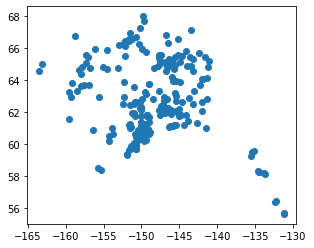

In [2]:
#convert the station list from above to points with geopandas
scgdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.lon, stations.lat),crs='epsg:4326')
scgdf.plot()

In [3]:
# add column with domain name to each snow course location
# run all AK domains
domain_list = ['BEAU','BRIS','CHUK','JUNE','KLAW','SITK','TAKU','YUKO']

for domain in domain_list:
    print(domain)
  
    # bounding box
    Bbox = domains[domain]['Bbox']

    # Snotel projection
    stn_proj = domains[domain]['stn_proj']
    # model projection
    mod_proj = domains[domain]['mod_proj']

    # Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
    box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
    box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)

    #clip snow course sites to domain bounding box
    gdf = gpd.sjoin(scgdf, box_gdf, how="inner")
    gdf.drop(columns='index_right', inplace=True)
    gdf.reset_index(drop=True, inplace=True)
    
    # add columns with projected coordinates 
    stn_proj = gdf.to_crs(mod_proj)
    gdf['easting'] = stn_proj.geometry.x
    gdf['northing'] = stn_proj.geometry.y
    
    # drop columns with measurement-specific information
    gdf_clean = gdf.drop(columns=['mon', 'day', 'year', 'snod', 'date'])

    print(gdf_clean.name)
    
    if len(gdf_clean)>0:
        print('exporting geojson file')
        # Export the sites to files, for reuse
        out = '/nfs/attic/dfh/2020_NPRB/data/snow_course/'+domain+'/Snow_course_'+domain+'.geojson'
        gdf_clean.to_file(out, driver='GeoJSON')
        
        # save out depth data for each domain
        # figure out unique observation dates 
        dates = []
        for code in gdf_clean.code:
            obs = sc.where(sc.id == code).dropna().reset_index(drop=True)
            dates.extend(obs.dt.tolist())
        # unique dates
        uqdates = np.unique(dates)
        # unique sites
        nams = gdf_clean.code.tolist()

        #build array of depth data
        data = np.empty([len(uqdates),len(nams)])
        for d in range(len(uqdates)):
            for n in range(len(nams)):
                # convert from cm to m
                try:
                    data[d,n] = sc.snod[(sc.id == nams[n])&(sc.dt==uqdates[d])].values[0]/100
                except:
                    data[d,n] = np.nan
        #turn into dataframe
        df = pd.DataFrame(data, index=uqdates, columns = nams)
        
        # Export the depth data to files, for reuse
        print('exporting hs data file')
        outP = '/nfs/attic/dfh/2020_NPRB/data/snow_course/'+domain+'/Snow_course_'+domain+'_snod_m.csv'
        df.to_csv(outP)
        
        # clip to calibration period 
        df_clip = df[(df.index.year>=cal_st)&(df.index.year<=cal_ed)]
        # drop rows and columns if all values are nan
        df_clip=df_clip.dropna(axis=1, how='all')
        df_clip=df_clip.dropna(axis=0, how='all')
        
        # Export the depth data to files, for reuse
        outP2 = '/nfs/attic/dfh/2020_NPRB/data/snow_course/'+domain+'/Snow_course_'+domain+'_snod_m_'+str(cal_st)+'_'+str(cal_ed)+'.csv'
        df_clip.to_csv(outP2)
        

BEAU
0    Disaster Creek
1    Table Mountain
Name: name, dtype: object
exporting geojson file
exporting hs data file
BRIS
0            Nikolai Creek
1           Bentalit Lodge
2             Nugget Bench
3                Kantishna
4             Bridge Creek
5     Demonstration Forest
6      Anchor River Divide
7               Eagle Lake
8            Mcneil Canyon
9              Port Graham
10                Nanwalek
11              Cytex Pass
12                Skwentna
13           Granite Point
14         Congahbuna Lake
15         Chuitna Plateau
16              Lone Ridge
17           Chelatna Lake
18         Purkeypile Mine
19        West Fork Yentna
20         Lake Minchumina
21          Telaquana Lake
22        Upper Twin Lakes
23           Port Alsworth
24           Fishtrap Lake
25     Lower Nowitna River
26             Brooks Camp
27             Three Forks
28                 Mcgrath
29         Hoholitna River
30            Upper Innoko
31             Wapoo Hills
32           M